In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import table
import os, sys, json
from pulp import *
from collections import OrderedDict

%matplotlib inline

In [2]:

# planning_length
planning_length = 1 

# Number of shifts per day:
daily_shift = [0, 1, 2]

# Label the days from Monday to Sunday. 
d = ['M', 'Tu', 'W', 'Th', 'F','Sa','Su']

# Create the required_agents dataframe
col = range(0, 7*planning_length)

required_agents = pd.DataFrame(data = None, columns=d, index = daily_shift)




#################    INSERT MANUAL INPUTS HERE     #################


#total number of agents:
total_agents = 20
print ("\nTotal number of agents are: {}".format(total_agents))

#agents per shift:
reqd_agents = 4
for j in col:
    required_agents.iloc[0][j] = reqd_agents
    required_agents.iloc[1][j] = reqd_agents
    required_agents.iloc[2][j] = reqd_agents

#Minimum and maximum shifts per agent, per week    
min_shifts_per_agent_per_week = 0
max_shifts_per_agent_per_week = 5
    

#################    INSERT INPUTS ABOVE     #################    
    

    
    
# List of number of agents required in specific shifts

r = required_agents.values.swapaxes(0,1).ravel()

print("\nThe number of agents required for each shift is: ")
print (r)
print("Total no. of shifts is: ", len(r))

print ("\nIn matrix form:")
print (required_agents.head())

# Create agents_id tag
agent_id = ['agent'+str(i) for i in range(total_agents)]
print ("\nThe agents are: ")
print (agent_id)


Total number of agents are: 20

The number of agents required for each shift is: 
[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
Total no. of shifts is:  21

In matrix form:
   M Tu  W Th  F Sa Su
0  4  4  4  4  4  4  4
1  4  4  4  4  4  4  4
2  4  4  4  4  4  4  4

The agents are: 
['agent0', 'agent1', 'agent2', 'agent3', 'agent4', 'agent5', 'agent6', 'agent7', 'agent8', 'agent9', 'agent10', 'agent11', 'agent12', 'agent13', 'agent14', 'agent15', 'agent16', 'agent17', 'agent18', 'agent19']


In [3]:
'''
shifts: label each shift. For example: Monday day shift is 0, afternoon is shift 1 Monday night shift is 2, etc.
agents: label each agent. Simply use integers to represent.
'''

# Total shifts
shifts = range(3*7*planning_length)
agents = range(total_agents)

## Create shift names based on index:
shift_name = []

for s in shifts:
    # find the day shift or mid shift or night shift
    if(s%3 == 1):
        shift_name.append(d[s//3] + '_' + 's2')
    elif (s%3 == 2):
        shift_name.append(d[s//3] + '_' + 's3')
    else:
        shift_name.append(d[s//3] + '_' + 's1')
    
    
print("The shifts are: ")
print(shifts)

print("\nThe names of corresponding shifts are: ")
print(shift_name)

print("\nThe agents are: ")
print(agents)

The shifts are: 
range(0, 21)

The names of corresponding shifts are: 
['M_s1', 'M_s2', 'M_s3', 'Tu_s1', 'Tu_s2', 'Tu_s3', 'W_s1', 'W_s2', 'W_s3', 'Th_s1', 'Th_s2', 'Th_s3', 'F_s1', 'F_s2', 'F_s3', 'Sa_s1', 'Sa_s2', 'Sa_s3', 'Su_s1', 'Su_s2', 'Su_s3']

The agents are: 
range(0, 20)


In [4]:
def LpProb():

    '''
    Use pulp to solve the constrained problem using linear programming(LP) algorithm. 
    1. Start the instance of a LpProblem: pulp.LpProblem(name_str, sense = 'LpMaxmize' or 'LpMinimize')
    2. Create LpVariables. Binary category in this case
    3. Add constraints in either equality or inequality conditions.
    4. Build objective function using LpObjective. 
    5. Use Solver to solve the problem, display the status and optimized values, using LpStatus.
    '''

    # The prob variable is created to contain the problem data   
    prob = LpProblem("Agents scheduling",LpMinimize)
    
    # Creating the decision variables. 
    var = {
     (n, s): pulp.LpVariable(
        "schdule_{0}_{1}".format(n, s), cat = "Binary")
        for n in agents for s in shifts
    }

    
    # adding constraints: 
    
    # 1: agents do not work in two consecutive days (i.e. out of 3 shifts in a day, work for max 1)
    ## If agent works for a night shift, he/she will take a next day off. This ensures min. 14 hrs break between 2 shifts

    for n in agents:
        for s in shifts:
            if s==shifts[-2]:
                prob.addConstraint(var[(n,s)] + var[(n, s+1)] <= 1)
            elif s == shifts[-1]:
                prob.addConstraint(var[(n,s)] <= 1)
            else:
                prob.addConstraint(var[(n,s)] + var[(n, s+1)] + var[(n, s+2)] <= 1)
                                
                
    # add constraints:
    # Request PTO or take a specific day off:
#     for n in agents:
#         if str(n) in shift_off:
#             for s in shift_off[str(n)]:
#                 prob.addConstraint(
#                 var[(n, s)] == 0
#                 )


    # add constraint:
    # 2: Working shifts should be either 0 to 5 in a week, per agent
    ## Here the first calculation is based on 
    for n in agents:
        prob.addConstraint(
        sum(var[(n,s)] for s in shifts) <= max_shifts_per_agent_per_week    
        )
        prob.addConstraint(
        sum(var[(n,s)] for s in shifts) >= min_shifts_per_agent_per_week
        )



    # add constraint:
    # 3: for each shift, the numbers of working agents should be greater than
    # the required numbers of agents
    for s in shifts:
        try:
            prob.addConstraint(
            sum(var[(n,s)] for n in agents) >= r[s]
            )
        except:
            print("len(shifts) should be equal to len(required_agents)")
            sys.exit(-1)   
    
    
    # add objective: minimize the numbers of total agents required
    
    
    prob.objective = sum(var[(n,s)] for n in agents for s in shifts)    
    
    return var, prob

In [5]:
## Run the solver

var, prob = LpProb()
prob.solve()
print(LpStatus[prob.status])

Optimal


C:\Users\19084\anaconda3\lib\site-packages\pulp\pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


In [6]:
# def check_off_shift():
#     # return True if the constraints have been satisfied otherwise return False

# #     for n in agents:
# #         if str(n) in shift_off:
# #             for s in shift_off[str(n)]:
# #                 if value(var[(n,s)]) == 1:
# #                     print(n, s)
# #                     return False

#     for n in agents:
#         for s in shifts:
#             if s == shifts[-1]:
#                 prob.addConstraint(var[(n,s)] <= 1)
#                 if value(var[(n,s)]) > 1:
#                     return False  # for day shift
#             elif s == shifts[-2]:
#                 if value(var[(n,s)]) + value(var[(n,s+1)]) > 1:
#                     return False
#             else:
#                 if value(var[(n,s)]) + value(var[(n,s+1)]) + value(var[(n, s+2)]) > 1:
#                     return False

#     for n in agents:
#         tmp = sum(value(var[(n,s)]) for s in shifts) 
#         if tmp > 5 or tmp < 0:
#             return False

# #     for n in agents:
# #         if sum(value(var[(n, s)]) for s in shifts if s%2) > 1:
# #             return False

#     for s in shifts:
#         try:
#             if sum(value(var[(n,s)]) for n in agents) < r[s]:
#                 return False
#         except:
#             print("len(shifts) should be equal to len(required_agents)")
#             sys.exit(-1)   

#     return True


# print("Check the all constraints: {}".format(check_off_shift()))

In [7]:
#create the schedule variable to iterate through the dataframe cells

def agent_scheduling(var = var):

    schedule = pd.DataFrame(data=None, index = agent_id, columns = shift_name)
    
    for k, v in var.items():
        n, s = k[0], k[1]
        if(int(value(v)) == 1):
            schedule.iloc[n][s] = "Working" # pulp.value()
        else:
            schedule.iloc[n][s] = "Leave"
        
    return schedule

In [8]:
#create the Report summary function for the overall report of the weekly roster

def summary(schedule):
    agents_with_no_shift = 0
    agents_with_one_shift = 0
    agents_with_two_shift = 0
    agents_with_three_shift = 0
    agents_with_four_shift = 0
    agents_with_five_shift = 0

    for i, row in schedule.iterrows():
        total_shifts = 0
        for j, column in row.iteritems():
            if column == "Working":
                total_shifts+=1

        if total_shifts == 1:
            agents_with_one_shift+=1
        elif total_shifts == 2:
            agents_with_two_shift+=1
        elif total_shifts == 3:
            agents_with_three_shift+=1
        elif total_shifts == 4:
            agents_with_four_shift+=1
        elif total_shifts == 5:
            agents_with_five_shift+=1
        else:
            agents_with_no_shift+=1

    print("Total agents are: ", total_agents)
    print("Total agents with 1 shift: ", agents_with_one_shift)
    print("Total agents with 2 shifts: ", agents_with_two_shift)
    print("Total agents with 3 shifts: ", agents_with_three_shift)
    print("Total agents with 4 shifts: ", agents_with_four_shift)
    print("Total agents with 5 shifts: ", agents_with_five_shift)
    print("Total agents with NO shifts: ", agents_with_no_shift)

In [9]:


schedule = agent_scheduling()
print(schedule)

shift_name_map = OrderedDict()    
schedule_dict = schedule.to_dict(into=OrderedDict)
for shift, agents_dict in schedule_dict.items():
    shift_name_map[shift] = []
    for agent, value in agents_dict.items():
        if value == "Working":
            shift_name_map[shift].append(agent)

#Store the shift name & it's corresponding agents allocated by PuLP, to pass it on to the 15-min interval code
%store shift_name_map
%store agent_id
print(shift_name_map)

            M_s1     M_s2     M_s3    Tu_s1    Tu_s2    Tu_s3     W_s1  \
agent0     Leave  Working    Leave    Leave    Leave  Working    Leave   
agent1     Leave    Leave    Leave    Leave  Working    Leave    Leave   
agent2     Leave    Leave  Working    Leave    Leave    Leave  Working   
agent3     Leave    Leave    Leave  Working    Leave    Leave  Working   
agent4     Leave  Working    Leave    Leave  Working    Leave    Leave   
agent5     Leave    Leave  Working    Leave    Leave    Leave    Leave   
agent6     Leave  Working    Leave    Leave    Leave  Working    Leave   
agent7   Working    Leave    Leave    Leave  Working    Leave    Leave   
agent8     Leave    Leave    Leave    Leave  Working    Leave    Leave   
agent9     Leave    Leave    Leave    Leave    Leave    Leave  Working   
agent10  Working    Leave    Leave    Leave    Leave    Leave  Working   
agent11    Leave    Leave  Working    Leave    Leave    Leave    Leave   
agent12    Leave    Leave    Leave  Wo

In [10]:
schedule.to_csv('schedule_3_shifts_per_day.csv')

In [11]:
def plot_table(df, figSize = (20,20), saveFig = False, figTitle = 'agent_scheduling'):
     
    colors = df.applymap(lambda x: 'lightcoral' if x== "Leave" else 'lightgreen') 

    fig = plt.figure(figsize=figSize)

    ax = plt.subplot(2, 1, 1, frame_on = True)  # no visible frame
    #ax.xaxis.set_visible(False)  # hide the x axis
    #ax.yaxis.set_visible(False)
    ax.axis('off')

    tb1 = table(ax,df,
                loc='center',
                cellLoc='center',
                cellColours=colors.values,
                fontsize=14
          )


    # refresh the plot
    plt.show()

The schedule of all agents: 


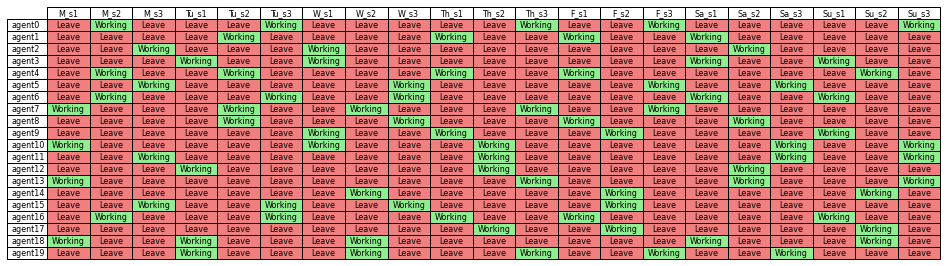

The summary report of the schedule created is: 
Total agents are:  20
Total agents with 1 shift:  0
Total agents with 2 shifts:  0
Total agents with 3 shifts:  4
Total agents with 4 shifts:  8
Total agents with 5 shifts:  8
Total agents with NO shifts:  0
The required agents are: 
[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]


In [12]:
print("The schedule of all agents: ")
plot_table(schedule, figSize = (16, 8), saveFig = True)

print("The summary report of the schedule created is: ")
summary(schedule)

print("The required agents are: ")
print(r)